# Задание

**Основная цель:** построить модель, которая будет предсказывать вероятность закрытия кредита раньше половины срока

**Необходимые этапы выполнения:**
* Первичная предобработка данных
  - Создание новых переменных + обоснование новых переменных
  - Анализ распределений + исключение ненужных выбросов и "кривых" данных
* Формулировка целевой переменной (что нужно предсказывать)
* Разделение выборки на обучающую и тестовую (или кроссвалидация) (+учет распределения классов)
* Обучение модели случайного леса
* Проверка качества (по метрикам из лекции)
* Значимость переменных
* Проверка стабильности (формулировка предложений проверки стабильности на новых данных)

**Описание переменных:**
* account_rk - уникальный номер кредитного счета
* utilization_dt - дата начала использования кредита
* credit_type - тип кредита
* duration - текущий срок жизни кредита
* deb_coming - сумма поступлений на дебетовую карту
* deb_transactions - сумма транзакций с дебетовой карты
* insurance_payment - платежи по страховке
* mob_days - кол-во дней, в которых использовалось мобильное приложение
* tarif_type - тип тарифа
* monthly_income_amt - доход
* rp - размер регулярного платежа по кредиту
* initial_term - изначальный срок по кредиту
* sum_approved - одобренная сумма кредита
* approv_vs_request - отношение одобренной суммы к запрошенной
* loyalty_coeff - коэффициент лояльности клиента
* segment - сегмент
* closed_flg - флаг закрытия кредита
* pd_model_new_norm- вероятность дефолта кредита

### Решение

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
exc = pd.read_csv('data_for_prediction.zip', compression='zip', sep=';')

exc

,Unnamed: 0,account_rk,utilization_dt,credit_type,duration,deb_coming,deb_transactions,insurance_payment,mob_days,tarif_type,monthly_income_amt,rp,initial_term,sum_approved,approv_vs_request,loyalty_coeff,segment,closed_flg,pd_model
0,47242,289097.0,2018-09-23,1,21.0,40814.0,-7191.0,0.0,10.0,one,103492.0,21716.0,36.0,530000.0,1.722223,0.0000,4.0,0.0,0.035133
1,122948,393796.0,2019-11-27,1,12.0,76528.0,12532.0,0.0,23.0,not_one,80094.0,11486.0,32.0,225000.0,-0.663957,0.0000,4.0,0.0,0.026019
2,201566,539112.0,2020-09-25,1,1.0,49854.0,28671.0,0.0,31.0,one,94485.0,17008.0,38.0,280000.0,-0.675823,0.2306,4.0,0.0,0.005385
3,27012,261769.0,2018-07-11,1,28.0,-6453.0,8454.0,0.0,3.0,not_one,63285.0,8925.0,38.0,230000.0,3.689388,0.0000,4.0,0.0,0.014340
4,94025,350912.0,2019-05-28,1,5.0,11070.0,-9936.0,0.0,19.0,one,66232.0,9990.0,39.0,155000.0,-0.276433,0.0000,4.0,0.0,0.059922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209801,112723,376079.0,2019-08-13,1,16.0,-7525.0,5656.0,0.0,17.0,one,42414.0,5656.0,34.0,-30000.0,1.295852,0.0000,3.0,0.0,0.009465
209802,92871,348633.0,2019-05-22,1,20.0,29024.0,-4126.0,0.0,6.0,one,71152.0,11488.0,39.0,410000.0,2.266996,0.0000,3.0,0.0,0.054881
209803,141120,421299.0,2019-12-27,1,12.0,84928.0,12882.0,2000.0,4.0,one,72298.0,13619.0,32.0,400000.0,-0.524158,0.2633,3.0,0.0,0.064074
209804,226526,593087.0,2020-11-28,1,7.0,-2533.0,1664.0,0.0,16.0,one,58465.0,4056.0,36.0,205000.0,-0.139872,0.0904,4.0,0.0,0.049788


##### Очистка данных

In [3]:
# удалим ненужный индекс
exc.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
# удалим данные с ошибкой (текущий срок действия кредита не может быть отрицательным)
exc = exc[exc['duration'] >= 0]

In [5]:
# удалим данные с ошибкой (размер регулярного платежа по кредиту не может быть отрицательным)
exc = exc[exc['rp'] > 0]

In [6]:
# удалим данные с ошибкой (одобренная сумма кредита не может быть отрицательной)
exc = exc[exc['sum_approved'] > 0]

In [7]:
# отрезаем отрицательные доходы
exc = exc[exc['deb_coming'] > 0]

In [8]:
# отрезаем отрицательные суммы транзакций
exc = exc[exc['deb_transactions'] > 0]

In [9]:
# посчитаем общую сумму к выплате
exc['total_sum'] = exc['rp'] * exc['initial_term']

# удалим данные с ошибкой (сумма выплат по кредиту не может быть меньше выданной суммы кредита) 
exc = exc[exc['total_sum'] >= exc['sum_approved']]

In [10]:
exc

,account_rk,utilization_dt,credit_type,duration,deb_coming,deb_transactions,insurance_payment,mob_days,tarif_type,monthly_income_amt,rp,initial_term,sum_approved,approv_vs_request,loyalty_coeff,segment,closed_flg,pd_model,total_sum
1,393796.0,2019-11-27,1,12.0,76528.0,12532.0,0.0,23.0,not_one,80094.0,11486.0,32.0,225000.0,-0.663957,0.0000,4.0,0.0,0.026019,367552.0
2,539112.0,2020-09-25,1,1.0,49854.0,28671.0,0.0,31.0,one,94485.0,17008.0,38.0,280000.0,-0.675823,0.2306,4.0,0.0,0.005385,646304.0
8,351471.0,2019-07-26,1,5.0,104116.0,127638.0,0.0,19.0,one,52308.0,18728.0,45.0,520000.0,-0.580683,0.0000,1.0,0.0,0.041785,842760.0
13,422294.0,2020-01-01,1,0.0,40190.0,13330.0,0.0,13.0,one,91575.0,15948.0,36.0,185000.0,2.264389,0.1642,4.0,0.0,0.073504,574128.0
18,258724.0,2018-07-10,1,21.0,230122.0,46087.0,0.0,11.0,one,86518.0,11031.0,44.0,285000.0,-0.237725,0.0000,4.0,1.0,0.009187,485364.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209786,505926.0,2020-07-14,1,15.0,77101.0,35529.0,0.0,22.0,not_one,63867.0,7951.0,26.0,145000.0,1.146411,0.1153,4.0,0.0,0.013730,206726.0
209797,537576.0,2020-09-09,1,12.0,23964.0,12632.0,0.0,12.0,one,65176.0,9014.0,34.0,105000.0,2.905617,0.2582,4.0,1.0,0.014361,306476.0
209799,375215.0,2019-08-08,1,15.0,56596.0,7994.0,0.0,32.0,one,145059.0,20541.0,34.0,335000.0,2.950345,0.0000,1.0,0.0,0.026298,698394.0
209800,403174.0,2019-11-17,1,8.0,15060.0,12186.0,0.0,16.0,not_one,124682.0,12962.0,27.0,245000.0,3.381394,0.0000,2.0,0.0,0.003915,349974.0


In [11]:
# проверка формата данных столбцов
exc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74778 entries, 1 to 209803
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account_rk          74778 non-null  float64
 1   utilization_dt      74778 non-null  object 
 2   credit_type         74778 non-null  int64  
 3   duration            74778 non-null  float64
 4   deb_coming          74778 non-null  float64
 5   deb_transactions    74778 non-null  float64
 6   insurance_payment   74778 non-null  float64
 7   mob_days            74778 non-null  float64
 8   tarif_type          74778 non-null  object 
 9   monthly_income_amt  74719 non-null  float64
 10  rp                  74778 non-null  float64
 11  initial_term        74778 non-null  float64
 12  sum_approved        74778 non-null  float64
 13  approv_vs_request   74753 non-null  float64
 14  loyalty_coeff       74778 non-null  float64
 15  segment             71566 non-null  float64
 16  clo

In [12]:
# преобразуем в формат даты
exc['utilization_dt'] = pd.to_datetime(exc.utilization_dt)

In [13]:
# проверка формата данных столбцов и пропущенных значений
exc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74778 entries, 1 to 209803
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   account_rk          74778 non-null  float64       
 1   utilization_dt      74778 non-null  datetime64[ns]
 2   credit_type         74778 non-null  int64         
 3   duration            74778 non-null  float64       
 4   deb_coming          74778 non-null  float64       
 5   deb_transactions    74778 non-null  float64       
 6   insurance_payment   74778 non-null  float64       
 7   mob_days            74778 non-null  float64       
 8   tarif_type          74778 non-null  object        
 9   monthly_income_amt  74719 non-null  float64       
 10  rp                  74778 non-null  float64       
 11  initial_term        74778 non-null  float64       
 12  sum_approved        74778 non-null  float64       
 13  approv_vs_request   74753 non-null  float64  

In [14]:
# сформируем список индексов с пропущенными значениями segment
segment_na_list = exc[exc['segment'].isna()].index.to_list()

In [15]:
# удалим строки согласно списку
exc = exc.drop(index=segment_na_list)

In [16]:
# проверка формата пропущенных значений
exc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71566 entries, 1 to 209803
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   account_rk          71566 non-null  float64       
 1   utilization_dt      71566 non-null  datetime64[ns]
 2   credit_type         71566 non-null  int64         
 3   duration            71566 non-null  float64       
 4   deb_coming          71566 non-null  float64       
 5   deb_transactions    71566 non-null  float64       
 6   insurance_payment   71566 non-null  float64       
 7   mob_days            71566 non-null  float64       
 8   tarif_type          71566 non-null  object        
 9   monthly_income_amt  71510 non-null  float64       
 10  rp                  71566 non-null  float64       
 11  initial_term        71566 non-null  float64       
 12  sum_approved        71566 non-null  float64       
 13  approv_vs_request   71542 non-null  float64  

In [17]:
# сформируем список индексов с пропущенными значениями monthly_income_amt
monthly_na_list = exc[exc['monthly_income_amt'].isna()].index.to_list()

In [18]:
# удалим строки согласно списку
exc = exc.drop(index=monthly_na_list)

In [19]:
# проверка формата пропущенных значений
exc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71510 entries, 1 to 209803
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   account_rk          71510 non-null  float64       
 1   utilization_dt      71510 non-null  datetime64[ns]
 2   credit_type         71510 non-null  int64         
 3   duration            71510 non-null  float64       
 4   deb_coming          71510 non-null  float64       
 5   deb_transactions    71510 non-null  float64       
 6   insurance_payment   71510 non-null  float64       
 7   mob_days            71510 non-null  float64       
 8   tarif_type          71510 non-null  object        
 9   monthly_income_amt  71510 non-null  float64       
 10  rp                  71510 non-null  float64       
 11  initial_term        71510 non-null  float64       
 12  sum_approved        71510 non-null  float64       
 13  approv_vs_request   71486 non-null  float64  

In [20]:
# сформируем список индексов с пропущенными значениями approv_vs_request
approve_na_list = exc[exc['approv_vs_request'].isna()].index.to_list()

In [21]:
# удалим строки согласно списку
exc = exc.drop(index=approve_na_list)

In [22]:
# проверка формата пропущенных значений
exc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71486 entries, 1 to 209803
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   account_rk          71486 non-null  float64       
 1   utilization_dt      71486 non-null  datetime64[ns]
 2   credit_type         71486 non-null  int64         
 3   duration            71486 non-null  float64       
 4   deb_coming          71486 non-null  float64       
 5   deb_transactions    71486 non-null  float64       
 6   insurance_payment   71486 non-null  float64       
 7   mob_days            71486 non-null  float64       
 8   tarif_type          71486 non-null  object        
 9   monthly_income_amt  71486 non-null  float64       
 10  rp                  71486 non-null  float64       
 11  initial_term        71486 non-null  float64       
 12  sum_approved        71486 non-null  float64       
 13  approv_vs_request   71486 non-null  float64  

In [23]:
# сформируем список индексов с пропущенными значениями pd_model
model_na_list = exc[exc['pd_model'].isna()].index.to_list()

In [24]:
# удалим строки согласно списку
exc = exc.drop(index=model_na_list)

In [25]:
# проверка формата пропущенных значений
exc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71473 entries, 1 to 209803
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   account_rk          71473 non-null  float64       
 1   utilization_dt      71473 non-null  datetime64[ns]
 2   credit_type         71473 non-null  int64         
 3   duration            71473 non-null  float64       
 4   deb_coming          71473 non-null  float64       
 5   deb_transactions    71473 non-null  float64       
 6   insurance_payment   71473 non-null  float64       
 7   mob_days            71473 non-null  float64       
 8   tarif_type          71473 non-null  object        
 9   monthly_income_amt  71473 non-null  float64       
 10  rp                  71473 non-null  float64       
 11  initial_term        71473 non-null  float64       
 12  sum_approved        71473 non-null  float64       
 13  approv_vs_request   71473 non-null  float64  

In [26]:
# перезададим индексы
exc.reset_index(drop=True, inplace=True)

exc

,account_rk,utilization_dt,credit_type,duration,deb_coming,deb_transactions,insurance_payment,mob_days,tarif_type,monthly_income_amt,rp,initial_term,sum_approved,approv_vs_request,loyalty_coeff,segment,closed_flg,pd_model,total_sum
0,393796.0,2019-11-27,1,12.0,76528.0,12532.0,0.0,23.0,not_one,80094.0,11486.0,32.0,225000.0,-0.663957,0.0000,4.0,0.0,0.026019,367552.0
1,539112.0,2020-09-25,1,1.0,49854.0,28671.0,0.0,31.0,one,94485.0,17008.0,38.0,280000.0,-0.675823,0.2306,4.0,0.0,0.005385,646304.0
2,351471.0,2019-07-26,1,5.0,104116.0,127638.0,0.0,19.0,one,52308.0,18728.0,45.0,520000.0,-0.580683,0.0000,1.0,0.0,0.041785,842760.0
3,422294.0,2020-01-01,1,0.0,40190.0,13330.0,0.0,13.0,one,91575.0,15948.0,36.0,185000.0,2.264389,0.1642,4.0,0.0,0.073504,574128.0
4,258724.0,2018-07-10,1,21.0,230122.0,46087.0,0.0,11.0,one,86518.0,11031.0,44.0,285000.0,-0.237725,0.0000,4.0,1.0,0.009187,485364.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71468,505926.0,2020-07-14,1,15.0,77101.0,35529.0,0.0,22.0,not_one,63867.0,7951.0,26.0,145000.0,1.146411,0.1153,4.0,0.0,0.013730,206726.0
71469,537576.0,2020-09-09,1,12.0,23964.0,12632.0,0.0,12.0,one,65176.0,9014.0,34.0,105000.0,2.905617,0.2582,4.0,1.0,0.014361,306476.0
71470,375215.0,2019-08-08,1,15.0,56596.0,7994.0,0.0,32.0,one,145059.0,20541.0,34.0,335000.0,2.950345,0.0000,1.0,0.0,0.026298,698394.0
71471,403174.0,2019-11-17,1,8.0,15060.0,12186.0,0.0,16.0,not_one,124682.0,12962.0,27.0,245000.0,3.381394,0.0000,2.0,0.0,0.003915,349974.0


##### Новые переменные

In [27]:
# генерируем поступления к rp
exc['deb_com_vs_rp'] = exc['deb_coming'] / exc['rp']
exc['deb_com_vs_sum'] = exc['deb_coming'] / exc['sum_approved']
exc['deb_com_vs_inc'] = exc['deb_coming'] / exc['monthly_income_amt']

In [28]:
# перекодируем тарифы в 1, остальные в 0
sub_map = {'not_one':0, 'one':1}
exc.tarif_type = exc.tarif_type.map(sub_map)

In [29]:
# создаем отдельные колонки для месяца и года
exc['month_num'] = exc['utilization_dt'].dt.month
exc['year_num'] = exc['utilization_dt'].dt.year

In [30]:
# создадим зависимую переменную
probability = []
for i in range(0, len(exc)):
    if exc['closed_flg'][i] == 1 and exc['duration'][i] < exc['initial_term'][i] / 2:
        probability.append(1)
    else:
        probability.append(0)
        
exc['probability'] = probability

exc

,account_rk,utilization_dt,credit_type,duration,deb_coming,deb_transactions,insurance_payment,mob_days,tarif_type,monthly_income_amt,...,segment,closed_flg,pd_model,total_sum,deb_com_vs_rp,deb_com_vs_sum,deb_com_vs_inc,month_num,year_num,probability
0,393796.0,2019-11-27,1,12.0,76528.0,12532.0,0.0,23.0,0,80094.0,...,4.0,0.0,0.026019,367552.0,6.662720,0.340124,0.955477,11,2019,0
1,539112.0,2020-09-25,1,1.0,49854.0,28671.0,0.0,31.0,1,94485.0,...,4.0,0.0,0.005385,646304.0,2.931209,0.178050,0.527639,9,2020,0
2,351471.0,2019-07-26,1,5.0,104116.0,127638.0,0.0,19.0,1,52308.0,...,1.0,0.0,0.041785,842760.0,5.559376,0.200223,1.990441,7,2019,0
3,422294.0,2020-01-01,1,0.0,40190.0,13330.0,0.0,13.0,1,91575.0,...,4.0,0.0,0.073504,574128.0,2.520065,0.217243,0.438875,1,2020,0
4,258724.0,2018-07-10,1,21.0,230122.0,46087.0,0.0,11.0,1,86518.0,...,4.0,1.0,0.009187,485364.0,20.861391,0.807446,2.659816,7,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71468,505926.0,2020-07-14,1,15.0,77101.0,35529.0,0.0,22.0,0,63867.0,...,4.0,0.0,0.013730,206726.0,9.697019,0.531731,1.207212,7,2020,0
71469,537576.0,2020-09-09,1,12.0,23964.0,12632.0,0.0,12.0,1,65176.0,...,4.0,1.0,0.014361,306476.0,2.658531,0.228229,0.367681,9,2020,1
71470,375215.0,2019-08-08,1,15.0,56596.0,7994.0,0.0,32.0,1,145059.0,...,1.0,0.0,0.026298,698394.0,2.755270,0.168943,0.390158,8,2019,0
71471,403174.0,2019-11-17,1,8.0,15060.0,12186.0,0.0,16.0,0,124682.0,...,2.0,0.0,0.003915,349974.0,1.161858,0.061469,0.120787,11,2019,0


##### Распределение переменных

In [31]:
# функция для построения распределений
def plot(data):
    %matplotlib inline
    plt.hist(data, color='#9b5de5', edgecolor='black', bins=60)
    plt.title('Распределение метрики')
    plt.xlabel('Значение метрики')
    plt.ylabel('Количество')
    plt.show()

In [32]:
# имена колонок в список
col_names = exc.columns.to_list()

account_rk


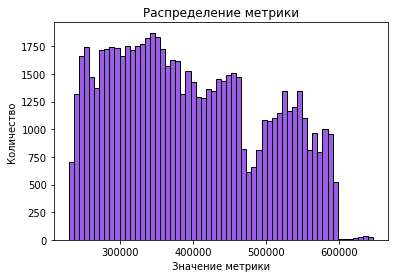

utilization_dt


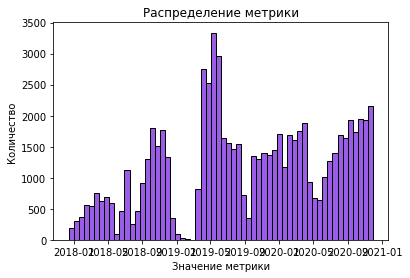

credit_type


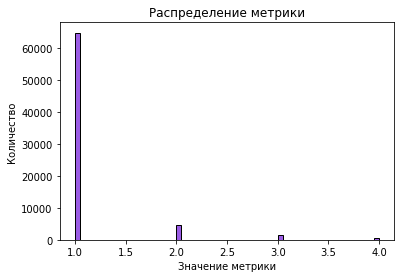

duration


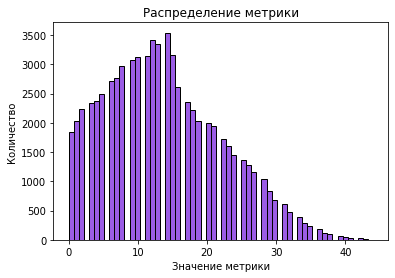

deb_coming


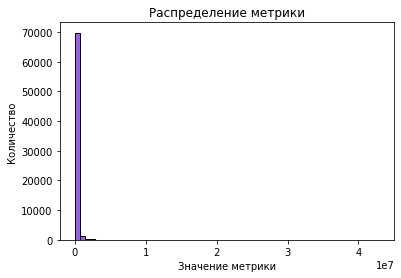

deb_transactions


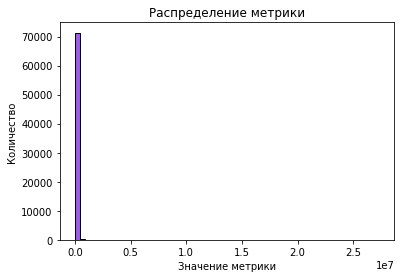

insurance_payment


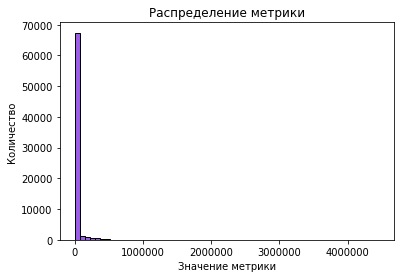

mob_days


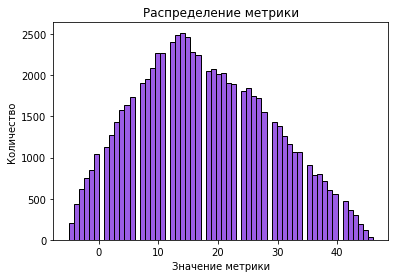

tarif_type


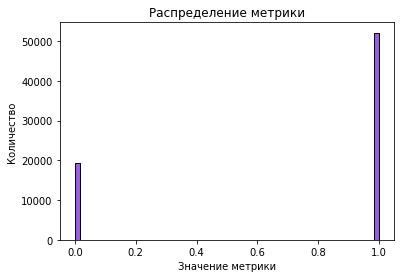

monthly_income_amt


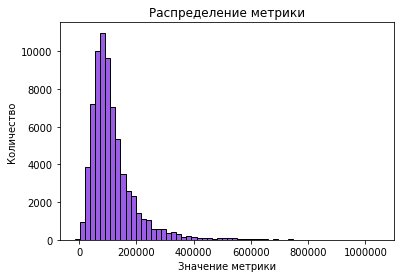

rp


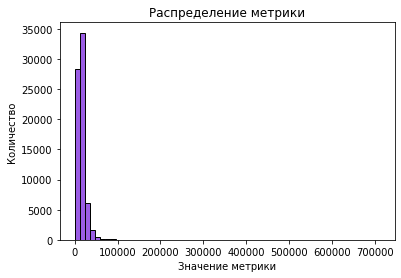

initial_term


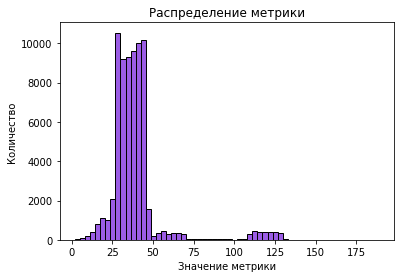

sum_approved


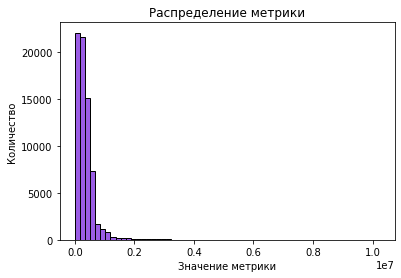

approv_vs_request


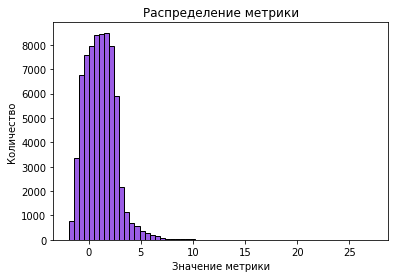

loyalty_coeff


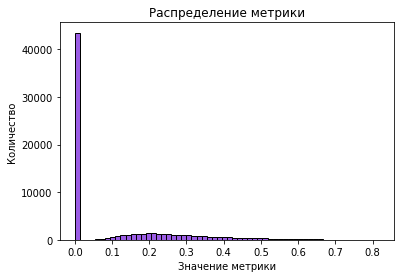

segment


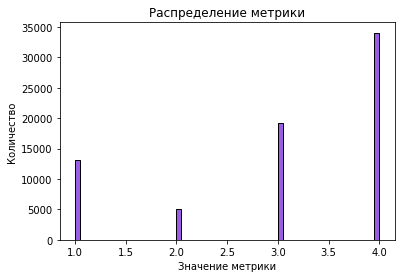

closed_flg


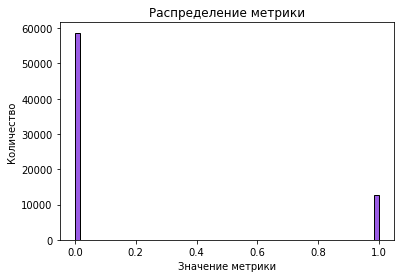

pd_model


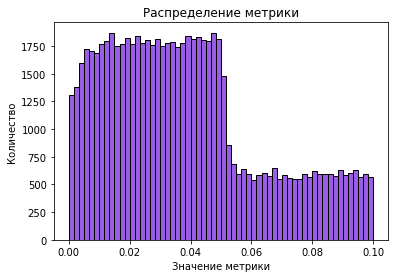

total_sum


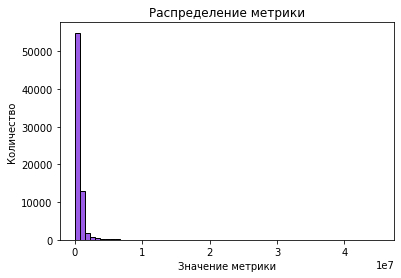

deb_com_vs_rp


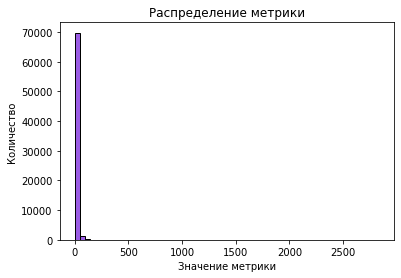

deb_com_vs_sum


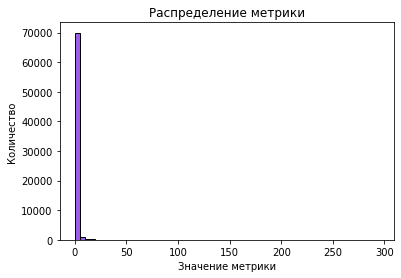

deb_com_vs_inc


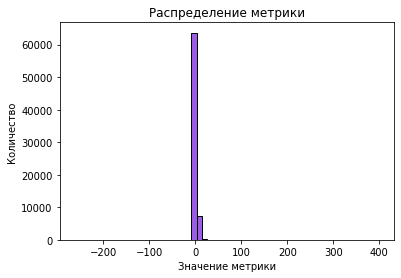

month_num


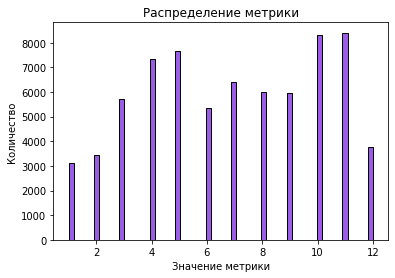

year_num


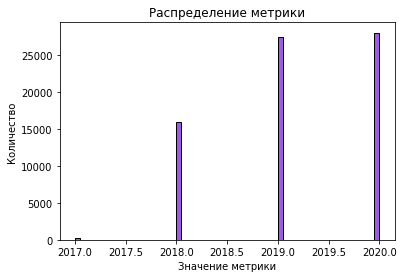

probability


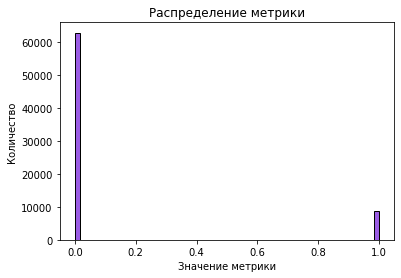

In [33]:
# построим графики
for col in col_names:
    print(col)
    plot(exc[col])

##### Отрезаем хвосты

In [34]:
exc

,account_rk,utilization_dt,credit_type,duration,deb_coming,deb_transactions,insurance_payment,mob_days,tarif_type,monthly_income_amt,...,segment,closed_flg,pd_model,total_sum,deb_com_vs_rp,deb_com_vs_sum,deb_com_vs_inc,month_num,year_num,probability
0,393796.0,2019-11-27,1,12.0,76528.0,12532.0,0.0,23.0,0,80094.0,...,4.0,0.0,0.026019,367552.0,6.662720,0.340124,0.955477,11,2019,0
1,539112.0,2020-09-25,1,1.0,49854.0,28671.0,0.0,31.0,1,94485.0,...,4.0,0.0,0.005385,646304.0,2.931209,0.178050,0.527639,9,2020,0
2,351471.0,2019-07-26,1,5.0,104116.0,127638.0,0.0,19.0,1,52308.0,...,1.0,0.0,0.041785,842760.0,5.559376,0.200223,1.990441,7,2019,0
3,422294.0,2020-01-01,1,0.0,40190.0,13330.0,0.0,13.0,1,91575.0,...,4.0,0.0,0.073504,574128.0,2.520065,0.217243,0.438875,1,2020,0
4,258724.0,2018-07-10,1,21.0,230122.0,46087.0,0.0,11.0,1,86518.0,...,4.0,1.0,0.009187,485364.0,20.861391,0.807446,2.659816,7,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71468,505926.0,2020-07-14,1,15.0,77101.0,35529.0,0.0,22.0,0,63867.0,...,4.0,0.0,0.013730,206726.0,9.697019,0.531731,1.207212,7,2020,0
71469,537576.0,2020-09-09,1,12.0,23964.0,12632.0,0.0,12.0,1,65176.0,...,4.0,1.0,0.014361,306476.0,2.658531,0.228229,0.367681,9,2020,1
71470,375215.0,2019-08-08,1,15.0,56596.0,7994.0,0.0,32.0,1,145059.0,...,1.0,0.0,0.026298,698394.0,2.755270,0.168943,0.390158,8,2019,0
71471,403174.0,2019-11-17,1,8.0,15060.0,12186.0,0.0,16.0,0,124682.0,...,2.0,0.0,0.003915,349974.0,1.161858,0.061469,0.120787,11,2019,0


In [35]:
# Отрезать будем по 95 квантилю
new = exc[(exc['deb_coming'] <= exc.deb_coming.quantile(q=0.95)) &
          (exc['deb_transactions'] <= exc.deb_transactions.quantile(q=0.95)) &
          (exc['insurance_payment'] <= exc.insurance_payment.quantile(q=0.95)) &
          (exc['monthly_income_amt'] <= exc.monthly_income_amt.quantile(q=0.95)) &
          (exc['rp'] <= exc.rp.quantile(q=0.95)) &
          (exc['sum_approved'] <= exc.sum_approved.quantile(q=0.95)) &
          (exc['deb_com_vs_rp'] <= exc.deb_com_vs_rp.quantile(q=0.95)) &
          (exc['deb_com_vs_inc'] <= exc.deb_com_vs_inc.quantile(q=0.95)) &
          (exc['deb_com_vs_sum'] <= exc.deb_com_vs_sum.quantile(q=0.95))]

new

,account_rk,utilization_dt,credit_type,duration,deb_coming,deb_transactions,insurance_payment,mob_days,tarif_type,monthly_income_amt,...,segment,closed_flg,pd_model,total_sum,deb_com_vs_rp,deb_com_vs_sum,deb_com_vs_inc,month_num,year_num,probability
0,393796.0,2019-11-27,1,12.0,76528.0,12532.0,0.0,23.0,0,80094.0,...,4.0,0.0,0.026019,367552.0,6.662720,0.340124,0.955477,11,2019,0
1,539112.0,2020-09-25,1,1.0,49854.0,28671.0,0.0,31.0,1,94485.0,...,4.0,0.0,0.005385,646304.0,2.931209,0.178050,0.527639,9,2020,0
3,422294.0,2020-01-01,1,0.0,40190.0,13330.0,0.0,13.0,1,91575.0,...,4.0,0.0,0.073504,574128.0,2.520065,0.217243,0.438875,1,2020,0
4,258724.0,2018-07-10,1,21.0,230122.0,46087.0,0.0,11.0,1,86518.0,...,4.0,1.0,0.009187,485364.0,20.861391,0.807446,2.659816,7,2018,1
6,433848.0,2020-01-30,1,20.0,8880.0,4750.0,0.0,16.0,1,26403.0,...,3.0,0.0,0.016896,279960.0,0.634376,0.039467,0.336325,1,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71468,505926.0,2020-07-14,1,15.0,77101.0,35529.0,0.0,22.0,0,63867.0,...,4.0,0.0,0.013730,206726.0,9.697019,0.531731,1.207212,7,2020,0
71469,537576.0,2020-09-09,1,12.0,23964.0,12632.0,0.0,12.0,1,65176.0,...,4.0,1.0,0.014361,306476.0,2.658531,0.228229,0.367681,9,2020,1
71470,375215.0,2019-08-08,1,15.0,56596.0,7994.0,0.0,32.0,1,145059.0,...,1.0,0.0,0.026298,698394.0,2.755270,0.168943,0.390158,8,2019,0
71471,403174.0,2019-11-17,1,8.0,15060.0,12186.0,0.0,16.0,0,124682.0,...,2.0,0.0,0.003915,349974.0,1.161858,0.061469,0.120787,11,2019,0


In [36]:
# проверка зависимой переменной
print(len(exc[exc['probability'] == 1]))
print(len(new[new['probability'] == 1]))

8757
5628


In [37]:
exc.year_num.value_counts()

2020    28012
2019    27393
2018    15885
2017      183
Name: year_num, dtype: int64

In [38]:
exc[exc['year_num'] == 2020].month_num.value_counts()

11    3307
10    3203
3     3083
9     3070
8     2912
2     2600
1     2500
7     2490
4     1942
6     1809
5     1096
Name: month_num, dtype: int64

In [39]:
# создаем df для отдельных месяцев 2020 года
df01 = exc[(exc['month_num'] == 1) & (exc['year_num'] == 2020)] 
df02 = exc[(exc['month_num'] == 2) & (exc['year_num'] == 2020)] 
df03 = exc[(exc['month_num'] == 3) & (exc['year_num'] == 2020)] 
df04 = exc[(exc['month_num'] == 4) & (exc['year_num'] == 2020)] 
df05 = exc[(exc['month_num'] == 5) & (exc['year_num'] == 2020)] 
df06 = exc[(exc['month_num'] == 6) & (exc['year_num'] == 2020)] 
df07 = exc[(exc['month_num'] == 7) & (exc['year_num'] == 2020)] 
df08 = exc[(exc['month_num'] == 8) & (exc['year_num'] == 2020)] 
df09 = exc[(exc['month_num'] == 9) & (exc['year_num'] == 2020)] 
df10 = exc[(exc['month_num'] == 10) & (exc['year_num'] == 2020)] 
df11 = exc[(exc['month_num'] == 11) & (exc['year_num'] == 2020)] 

print(len(df01), len(df02), len(df03), 
      len(df04), len(df05), len(df06), 
      len(df07), len(df08), len(df09),
     len(df10), len(df11), sep='\n')

2500
2600
3083
1942
1096
1809
2490
2912
3070
3203
3307


In [40]:
x_01 = df01.iloc[:, 3:15].values
x_02 = df02.iloc[:, 3:15].values
x_03 = df03.iloc[:, 3:15].values
x_04 = df04.iloc[:, 3:15].values
x_05 = df05.iloc[:, 3:15].values
x_06 = df06.iloc[:, 3:15].values
x_07 = df07.iloc[:, 3:15].values
x_08 = df08.iloc[:, 3:15].values
x_09 = df09.iloc[:, 3:15].values
x_10 = df10.iloc[:, 3:15].values
x_11 = df11.iloc[:, 3:15].values

##### Формируем обучающую выборку

In [41]:
# доля тех кто досрочно закрыл кредит (раньше половины срока)
print(len(new[new['probability'] == 1])/ len(new))

0.10407574524742955


In [42]:
exc_0 = new[new['probability'] == 0]  # не закрыли 
exc_1 = new[new['probability'] == 1]  # закрыли

print(len(exc_1))
print(len(exc_0))
print(len(exc_0) / len(exc_1))  # соотношение не закрытых кредитов к закрытым в нашей выборке

5628
48448
8.608386638237384


In [43]:
# выравниваем выборки в несколько проходов
first = exc_0.sample(frac=1/8, random_state=20)
first_rest = exc_0.drop(first.index)

second = first_rest.sample(frac=1/7, random_state=19)
second_rest = first_rest.drop(second.index)

third = second_rest.sample(frac=1/6, random_state=18)
third_rest = second_rest.drop(third.index)

fourth = third_rest.sample(frac=1/5, random_state=17)
fourt_rest = third_rest.drop(fourth.index)

fifth = fourt_rest.sample(frac=1/4, random_state=16)
fifth_rest = fourt_rest.drop(fifth.index)

sixth = fifth_rest.sample(frac=1/3, random_state=15)
sixth_rest = fifth_rest.drop(sixth.index)

seventh = sixth_rest.sample(frac=1/2, random_state=14)
seventh_rest = sixth_rest.drop(seventh.index)

eights = sixth_rest.drop(seventh.index)

In [44]:
# сделаем выборки и посмотрим как будут различаться результаты модели
pp_1 = exc_1.append(first)
pp_2 = exc_1.append(second)
pp_3 = exc_1.append(third)
pp_4 = exc_1.append(fourth)
pp_5 = exc_1.append(fifth)
pp_6 = exc_1.append(sixth)
pp_7 = exc_1.append(seventh)
pp_8 = exc_1.append(eights)

len(pp_8)

11684

##### Сделаем случайный выбор выборки

In [45]:
pack = [pp_1, pp_2, pp_3, pp_4, pp_5, pp_6, pp_7, pp_8]

In [46]:
from random import randrange

# берем случайное число
num = randrange(8)
print(num)

1


In [47]:
pp_5

,account_rk,utilization_dt,credit_type,duration,deb_coming,deb_transactions,insurance_payment,mob_days,tarif_type,monthly_income_amt,...,segment,closed_flg,pd_model,total_sum,deb_com_vs_rp,deb_com_vs_sum,deb_com_vs_inc,month_num,year_num,probability
4,258724.0,2018-07-10,1,21.0,230122.0,46087.0,0.0,11.0,1,86518.0,...,4.0,1.0,0.009187,485364.0,20.861391,0.807446,2.659816,7,2018,1
14,405654.0,2019-12-09,1,2.0,50885.0,6231.0,0.0,31.0,1,73176.0,...,3.0,1.0,0.060938,144400.0,6.695395,0.726929,0.695378,12,2019,1
16,338045.0,2019-04-18,1,3.0,23824.0,7697.0,0.0,-2.0,1,162010.0,...,4.0,1.0,0.034172,869435.0,0.959060,0.041433,0.147053,4,2019,1
38,522409.0,2020-08-11,1,7.0,110579.0,19326.0,0.0,32.0,1,127426.0,...,1.0,1.0,0.085706,486780.0,6.360598,0.325232,0.867790,8,2020,1
40,341348.0,2019-04-26,1,14.0,45344.0,9417.0,0.0,12.0,1,95198.0,...,4.0,1.0,0.048985,549003.0,3.221141,0.110595,0.476313,4,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50334,475068.0,2020-05-05,1,9.0,156562.0,30968.0,40000.0,13.0,1,199466.0,...,1.0,0.0,0.023964,642558.0,10.233479,0.248511,0.784906,5,2020,0
19843,243151.0,2018-03-04,1,15.0,4342.0,7975.0,0.0,15.0,1,51687.0,...,4.0,0.0,0.093796,272160.0,0.638154,0.043420,0.084006,3,2018,0
60509,288322.0,2019-01-03,1,17.0,2666.0,4521.0,0.0,6.0,0,55560.0,...,3.0,0.0,0.000376,202436.0,0.342409,0.021328,0.047984,1,2019,0
28221,247804.0,2018-03-31,1,18.0,44765.0,14363.0,0.0,19.0,1,87874.0,...,4.0,0.0,0.022302,306180.0,3.947531,0.596867,0.509423,3,2018,0


In [48]:
pack[num].columns

Index(['account_rk', 'utilization_dt', 'credit_type', 'duration', 'deb_coming',
       'deb_transactions', 'insurance_payment', 'mob_days', 'tarif_type',
       'monthly_income_amt', 'rp', 'initial_term', 'sum_approved',
       'approv_vs_request', 'loyalty_coeff', 'segment', 'closed_flg',
       'pd_model', 'total_sum', 'deb_com_vs_rp', 'deb_com_vs_sum',
       'deb_com_vs_inc', 'month_num', 'year_num', 'probability'],
      dtype='object')

In [49]:
pack[num].columns[3:15]

Index(['duration', 'deb_coming', 'deb_transactions', 'insurance_payment',
       'mob_days', 'tarif_type', 'monthly_income_amt', 'rp', 'initial_term',
       'sum_approved', 'approv_vs_request', 'loyalty_coeff'],
      dtype='object')

In [50]:
y = pack[num].iloc[:, 24].values  # зависимая переменная 
x = pack[num].iloc[:, 3:15].values  # независимые переменные

In [51]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [52]:
from sklearn.model_selection import train_test_split

# формируем обучающую и тестовую выборки
# x - вектор значений признаков, y - вектор со значениями целевой переменной
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=4)

In [53]:
print(len(X_train))
print(len(X_test))

8178
3506


##### Классифицируем

In [54]:
from sklearn.ensemble import RandomForestClassifier

# обучение модели слуйчаного леса
regressor = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=3)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [55]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# проверка качества
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 807 1014]
 [ 233 1452]]
              precision    recall  f1-score   support

           0       0.78      0.44      0.56      1821
           1       0.59      0.86      0.70      1685

    accuracy                           0.64      3506
   macro avg       0.68      0.65      0.63      3506
weighted avg       0.69      0.64      0.63      3506



##### ROC-AUC

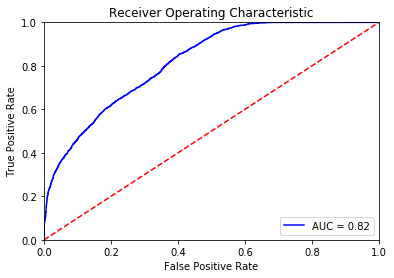

In [56]:
# TRAIN
from sklearn import metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = regressor.predict_proba(X_train)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### PR-AUC

auc=0.613


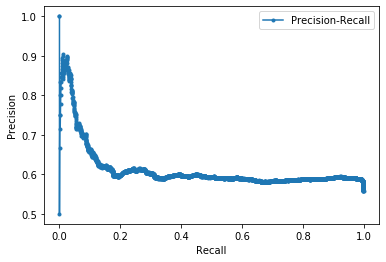

In [57]:
#TEST
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot

probs = regressor.predict_proba(X_test)
preds = probs[:,1]

lr_precision, lr_recall, _ = precision_recall_curve(y_test, preds)
lr_auc = auc(lr_recall, lr_precision)
print('auc=%.3f' % (lr_auc))

# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

auc=0.804


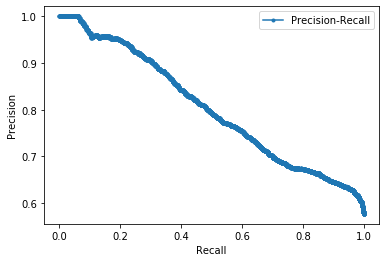

In [58]:
#TRAIN
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot

probs = regressor.predict_proba(X_train)
preds = probs[:,1]

lr_precision, lr_recall, _ = precision_recall_curve(y_train, preds)
lr_auc = auc(lr_recall, lr_precision)
print('auc=%.3f' % (lr_auc))

# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [59]:
regressor.classes_

array([0, 1])

In [60]:
# Предсказываем класс (x_07 - вектор со значениями переменных)
pred_class7 = regressor.predict(x_07)

# Предсказываем вероятности попадания в класс 1 (x_07 - вектор со значениями переменных)
prob_class_7 = regressor.predict_proba(x_07)[:,1]

In [61]:
print(np.count_nonzero(pred_class7) / len(df07))

0.8698795180722891


##### Значимость переменных

In [62]:
c = regressor.feature_importances_
for i,v in enumerate(c):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.53524
Feature: 1, Score: 0.03341
Feature: 2, Score: 0.03279
Feature: 3, Score: 0.04168
Feature: 4, Score: 0.02730
Feature: 5, Score: 0.00283
Feature: 6, Score: 0.03352
Feature: 7, Score: 0.03304
Feature: 8, Score: 0.12768
Feature: 9, Score: 0.03210
Feature: 10, Score: 0.03216
Feature: 11, Score: 0.06825


In [63]:
# Соотносим фичи и названия переменных (топ-3)
features = pp_5.columns[3:15]
print(features[0], features[8], features[11], sep='\n')

duration
initial_term
loyalty_coeff


##### Точность и стабильность результатов

In [64]:
# Предсказываем вероятности для остальных месяцев
prob_class_1 = regressor.predict_proba(x_01)[:, 1]
prob_class_2 = regressor.predict_proba(x_02)[:, 1]
prob_class_3 = regressor.predict_proba(x_03)[:, 1]
prob_class_4 = regressor.predict_proba(x_04)[:, 1]
prob_class_5 = regressor.predict_proba(x_05)[:, 1]
prob_class_6 = regressor.predict_proba(x_06)[:, 1]
prob_class_7 = regressor.predict_proba(x_07)[:, 1]
prob_class_8 = regressor.predict_proba(x_08)[:, 1]
prob_class_9 = regressor.predict_proba(x_09)[:, 1]
prob_class_10 = regressor.predict_proba(x_10)[:, 1]
prob_class_11 = regressor.predict_proba(x_11)[:, 1]

In [65]:
# добавляем предсказания в датафреймы
df01['results'] = list(prob_class_1)
df02['results'] = list(prob_class_2)
df03['results'] = list(prob_class_3)
df04['results'] = list(prob_class_4)
df05['results'] = list(prob_class_5)
df06['results'] = list(prob_class_6)
df07['results'] = list(prob_class_7)
df08['results'] = list(prob_class_8)
df09['results'] = list(prob_class_9)
df10['results'] = list(prob_class_10)
df11['results'] = list(prob_class_11)

/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nktnlx/yes/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [66]:
# вероятность >= 60%
prob01_6 = df01[df01['results'] >= 0.6]
prob02_6 = df02[df02['results'] >= 0.6]
prob03_6 = df03[df03['results'] >= 0.6]
prob04_6 = df04[df04['results'] >= 0.6]
prob05_6 = df05[df05['results'] >= 0.6]
prob06_6 = df06[df06['results'] >= 0.6]
prob07_6 = df07[df07['results'] >= 0.6]
prob08_6 = df08[df08['results'] >= 0.6]
prob09_6 = df09[df09['results'] >= 0.6]
prob10_6 = df10[df10['results'] >= 0.6]
prob11_6 = df11[df11['results'] >= 0.6]

In [67]:
# вероятность >= 70%
prob01_7 = df01[df01['results'] >= 0.7]
prob02_7 = df02[df02['results'] >= 0.7]
prob03_7 = df03[df03['results'] >= 0.7]
prob04_7 = df04[df04['results'] >= 0.7]
prob05_7 = df05[df05['results'] >= 0.7]
prob06_7 = df06[df06['results'] >= 0.7]
prob07_7 = df07[df07['results'] >= 0.7]
prob08_7 = df08[df08['results'] >= 0.7]
prob09_7 = df09[df09['results'] >= 0.7]
prob10_7 = df10[df10['results'] >= 0.7]
prob11_7 = df11[df11['results'] >= 0.7]

In [68]:
# вероятность >= 80%
prob01_8 = df01[df01['results'] >= 0.8]
prob02_8 = df02[df02['results'] >= 0.8]
prob03_8 = df03[df03['results'] >= 0.8]
prob04_8 = df04[df04['results'] >= 0.8]
prob05_8 = df05[df05['results'] >= 0.8]
prob06_8 = df06[df06['results'] >= 0.8]
prob07_8 = df07[df07['results'] >= 0.8]
prob08_8 = df08[df08['results'] >= 0.8]
prob09_8 = df09[df09['results'] >= 0.8]
prob10_8 = df10[df10['results'] >= 0.8]
prob11_8 = df11[df11['results'] >= 0.8]

In [69]:
# вероятность >= 90%
prob01_9 = df01[df01['results'] >= 0.9]
prob02_9 = df02[df02['results'] >= 0.9]
prob03_9 = df03[df03['results'] >= 0.9]
prob04_9 = df04[df04['results'] >= 0.9]
prob05_9 = df05[df05['results'] >= 0.9]
prob06_9 = df06[df06['results'] >= 0.9]
prob07_9 = df07[df07['results'] >= 0.9]
prob08_9 = df08[df08['results'] >= 0.9]
prob09_9 = df09[df09['results'] >= 0.9]
prob10_9 = df10[df10['results'] >= 0.9]
prob11_9 = df11[df11['results'] >= 0.9]

In [70]:
ins01 = df01[df01['closed_flg'] == 1]
ins02 = df02[df02['closed_flg'] == 1]
ins03 = df03[df03['closed_flg'] == 1]
ins04 = df04[df04['closed_flg'] == 1]
ins05 = df05[df05['closed_flg'] == 1]
ins06 = df06[df06['closed_flg'] == 1]
ins07 = df07[df07['closed_flg'] == 1]
ins08 = df08[df08['closed_flg'] == 1]
ins09 = df09[df09['closed_flg'] == 1]
ins10 = df10[df10['closed_flg'] == 1]
ins11 = df11[df11['closed_flg'] == 1]

**Вероятность 60%**

In [71]:
res1_6 = prob01_6['account_rk'].isin(ins01['account_rk'])
print('Результаты января 60%')
print('Всего ранних закрытий', sum(res1_6))
print('Доля ранних закрытий от предсказанных', sum(res1_6)/len(prob01_6), '\n')

res2_6 = prob02_6['account_rk'].isin(ins02['account_rk'])
print('Результаты февраля 60%')
print('Всего ранних закрытий', sum(res2_6))
print('Доля ранних закрытий от предсказанных', sum(res2_6)/len(prob02_6), '\n')

res3_6 = prob03_6['account_rk'].isin(ins03['account_rk'])
print('Результаты марта 60%')
print('Всего ранних закрытий', sum(res3_6))
print('Доля ранних закрытий от предсказанных', sum(res3_6)/len(prob03_6), '\n')

res4_6 = prob04_6['account_rk'].isin(ins04['account_rk'])
print('Результаты апреля 60%')
print('Всего ранних закрытий', sum(res4_6))
print('Доля ранних закрытий от предсказанных', sum(res4_6)/len(prob04_6), '\n')

res5_6 = prob05_6['account_rk'].isin(ins05['account_rk'])
print('Результаты майя 60%')
print('Всего ранних закрытий', sum(res5_6))
print('Доля ранних закрытий от предсказанных', sum(res5_6)/len(prob05_6), '\n')

res6_6 = prob06_6['account_rk'].isin(ins06['account_rk'])
print('Результаты июня 60%')
print('Всего ранних закрытий', sum(res6_6))
print('Доля ранних закрытий от предсказанных', sum(res6_6)/len(prob06_6), '\n')

res7_6 = prob07_6['account_rk'].isin(ins07['account_rk'])
print('Результаты июля 60%')
print('Всего ранних закрытий', sum(res7_6))
print('Доля ранних закрытий от предсказанных', sum(res7_6)/len(prob07_6), '\n')

res8_6 = prob08_6['account_rk'].isin(ins08['account_rk'])
print('Результаты августа 60%')
print('Всего ранних закрытий', sum(res8_6))
print('Доля ранних закрытий от предсказанных', sum(res8_6)/len(prob08_6), '\n')

res9_6 = prob09_6['account_rk'].isin(ins09['account_rk'])
print('Результаты сентября 60%')
print('Всего ранних закрытий', sum(res9_6))
print('Доля ранних закрытий от предсказанных', sum(res9_6)/len(prob09_6), '\n')

res10_6 = prob10_6['account_rk'].isin(ins10['account_rk'])
print('Результаты октября 60%')
print('Всего ранних закрытий', sum(res10_6))
print('Доля ранних закрытий от предсказанных', sum(res10_6)/len(prob10_6), '\n')

res11_6 = prob11_6['account_rk'].isin(ins11['account_rk'])
print('Результаты ноября 60%')
print('Всего ранних закрытий', sum(res11_6))
print('Доля ранних закрытий от предсказанных', sum(res11_6)/len(prob11_6), '\n')

Результаты января 60%
Всего ранних закрытий 135
Доля ранних закрытий от предсказанных 0.3333333333333333 

Результаты февраля 60%
Всего ранних закрытий 137
Доля ранних закрытий от предсказанных 0.31422018348623854 

Результаты марта 60%
Всего ранних закрытий 154
Доля ранних закрытий от предсказанных 0.29844961240310075 

Результаты апреля 60%
Всего ранних закрытий 100
Доля ранних закрытий от предсказанных 0.2994011976047904 

Результаты майя 60%
Всего ранних закрытий 81
Доля ранних закрытий от предсказанных 0.3521739130434783 

Результаты июня 60%
Всего ранних закрытий 139
Доля ранних закрытий от предсказанных 0.3483709273182957 

Результаты июля 60%
Всего ранних закрытий 158
Доля ранних закрытий от предсказанных 0.31287128712871287 

Результаты августа 60%
Всего ранних закрытий 153
Доля ранних закрытий от предсказанных 0.2833333333333333 

Результаты сентября 60%
Всего ранних закрытий 179
Доля ранних закрытий от предсказанных 0.3080895008605852 

Результаты октября 60%
Всего ранних за

**Вероятность 70%**

In [72]:
res1_6 = prob01_7['account_rk'].isin(ins01['account_rk'])
print('Результаты января 70%')
print('Всего ранних закрытий', sum(res1_6))
print('Доля ранних закрытий от предсказанных', sum(res1_6)/len(prob01_7), '\n')

res2_6 = prob02_7['account_rk'].isin(ins02['account_rk'])
print('Результаты февраля 70%')
print('Всего ранних закрытий', sum(res2_6))
print('Доля ранних закрытий от предсказанных', sum(res2_6)/len(prob02_7), '\n')

res3_6 = prob03_7['account_rk'].isin(ins03['account_rk'])
print('Результаты марта 70%')
print('Всего ранних закрытий', sum(res3_6))
print('Доля ранних закрытий от предсказанных', sum(res3_6)/len(prob03_7), '\n')

res4_6 = prob04_7['account_rk'].isin(ins04['account_rk'])
print('Результаты апреля 70%')
print('Всего ранних закрытий', sum(res4_6))
print('Доля ранних закрытий от предсказанных', sum(res4_6)/len(prob04_7), '\n')

res5_6 = prob05_7['account_rk'].isin(ins05['account_rk'])
print('Результаты майя 70%')
print('Всего ранних закрытий', sum(res5_6))
print('Доля ранних закрытий от предсказанных', sum(res5_6)/len(prob05_7), '\n')

res6_6 = prob06_7['account_rk'].isin(ins06['account_rk'])
print('Результаты июня 70%')
print('Всего ранних закрытий', sum(res6_6))
print('Доля ранних закрытий от предсказанных', sum(res6_6)/len(prob06_7), '\n')

res7_6 = prob07_7['account_rk'].isin(ins07['account_rk'])
print('Результаты июля 70%')
print('Всего ранних закрытий', sum(res7_6))
print('Доля ранних закрытий от предсказанных', sum(res7_6)/len(prob07_7), '\n')

res8_6 = prob08_7['account_rk'].isin(ins08['account_rk'])
print('Результаты августа 70%')
print('Всего ранних закрытий', sum(res8_6))
print('Доля ранних закрытий от предсказанных', sum(res8_6)/len(prob08_7), '\n')

res9_6 = prob09_7['account_rk'].isin(ins09['account_rk'])
print('Результаты сентября 70%')
print('Всего ранних закрытий', sum(res9_6))
print('Доля ранних закрытий от предсказанных', sum(res9_6)/len(prob09_7), '\n')

res10_6 = prob10_7['account_rk'].isin(ins10['account_rk'])
print('Результаты октября 70%')
print('Всего ранних закрытий', sum(res10_6))
print('Доля ранних закрытий от предсказанных', sum(res10_6)/len(prob10_7), '\n')

res11_6 = prob11_7['account_rk'].isin(ins11['account_rk'])
print('Результаты ноября 70%')
print('Всего ранних закрытий', sum(res11_6))
print('Доля ранних закрытий от предсказанных', sum(res11_6)/len(prob11_7), '\n')

Результаты января 70%
Всего ранних закрытий 35
Доля ранних закрытий от предсказанных 0.5737704918032787 

Результаты февраля 70%
Всего ранних закрытий 28
Доля ранних закрытий от предсказанных 0.5384615384615384 

Результаты марта 70%
Всего ранних закрытий 34
Доля ранних закрытий от предсказанных 0.5151515151515151 

Результаты апреля 70%
Всего ранних закрытий 24
Доля ранних закрытий от предсказанных 0.4897959183673469 

Результаты майя 70%
Всего ранних закрытий 18
Доля ранних закрытий от предсказанных 0.5294117647058824 

Результаты июня 70%
Всего ранних закрытий 29
Доля ранних закрытий от предсказанных 0.4461538461538462 

Результаты июля 70%
Всего ранних закрытий 44
Доля ранних закрытий от предсказанных 0.4835164835164835 

Результаты августа 70%
Всего ранних закрытий 38
Доля ранних закрытий от предсказанных 0.4935064935064935 

Результаты сентября 70%
Всего ранних закрытий 40
Доля ранних закрытий от предсказанных 0.47619047619047616 

Результаты октября 70%
Всего ранних закрытий 41


**Вероятность 80%**

In [73]:
res1_6 = prob01_8['account_rk'].isin(ins01['account_rk'])
print('Результаты января 80%')
print('Всего ранних закрытий', sum(res1_6))
print('Доля ранних закрытий от предсказанных', sum(res1_6)/len(prob01_8), '\n')

res2_6 = prob02_8['account_rk'].isin(ins02['account_rk'])
print('Результаты февраля 80%')
print('Всего ранних закрытий', sum(res2_6))
print('Доля ранних закрытий от предсказанных', sum(res2_6)/len(prob02_8), '\n')

res3_6 = prob03_8['account_rk'].isin(ins03['account_rk'])
print('Результаты марта 80%')
print('Всего ранних закрытий', sum(res3_6))
print('Доля ранних закрытий от предсказанных', sum(res3_6)/len(prob03_8), '\n')

res4_6 = prob04_8['account_rk'].isin(ins04['account_rk'])
print('Результаты апреля 80%')
print('Всего ранних закрытий', sum(res4_6))
print('Доля ранних закрытий от предсказанных', sum(res4_6)/len(prob04_8), '\n')

res5_6 = prob05_8['account_rk'].isin(ins05['account_rk'])
print('Результаты майя 80%')
print('Всего ранних закрытий', sum(res5_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res5_6)/len(prob05_8), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')

res6_6 = prob06_8['account_rk'].isin(ins06['account_rk'])
print('Результаты июня 80%')
print('Всего ранних закрытий', sum(res6_6))
print('Доля ранних закрытий от предсказанных', sum(res6_6)/len(prob06_8), '\n')

res7_6 = prob07_8['account_rk'].isin(ins07['account_rk'])
print('Результаты июля 80%')
print('Всего ранних закрытий', sum(res7_6))
print('Доля ранних закрытий от предсказанных', sum(res7_6)/len(prob07_8), '\n')

res8_6 = prob08_8['account_rk'].isin(ins08['account_rk'])
print('Результаты августа 80%')
print('Всего ранних закрытий', sum(res8_6))
print('Доля ранних закрытий от предсказанных', sum(res8_6)/len(prob08_8), '\n')

res9_6 = prob09_8['account_rk'].isin(ins09['account_rk'])
print('Результаты сентября 80%')
print('Всего ранних закрытий', sum(res9_6))
print('Доля ранних закрытий от предсказанных', sum(res9_6)/len(prob09_8), '\n')

res10_6 = prob10_8['account_rk'].isin(ins10['account_rk'])
print('Результаты октября 80%')
print('Всего ранних закрытий', sum(res10_6))
print('Доля ранних закрытий от предсказанных', sum(res10_6)/len(prob10_8), '\n')

res11_6 = prob11_8['account_rk'].isin(ins11['account_rk'])
print('Результаты ноября 80%')
print('Всего ранних закрытий', sum(res11_6))
print('Доля ранних закрытий от предсказанных', sum(res11_6)/len(prob11_8), '\n')

Результаты января 80%
Всего ранних закрытий 9
Доля ранних закрытий от предсказанных 0.6428571428571429 

Результаты февраля 80%
Всего ранних закрытий 3
Доля ранних закрытий от предсказанных 0.5 

Результаты марта 80%
Всего ранних закрытий 3
Доля ранних закрытий от предсказанных 0.42857142857142855 

Результаты апреля 80%
Всего ранних закрытий 4
Доля ранних закрытий от предсказанных 0.6666666666666666 

Результаты майя 80%
Всего ранних закрытий 2
Доля ранних закрытий от предсказанных 1.0 

Результаты июня 80%
Всего ранних закрытий 4
Доля ранних закрытий от предсказанных 0.5 

Результаты июля 80%
Всего ранних закрытий 5
Доля ранних закрытий от предсказанных 0.5555555555555556 

Результаты августа 80%
Всего ранних закрытий 5
Доля ранних закрытий от предсказанных 0.7142857142857143 

Результаты сентября 80%
Всего ранних закрытий 4
Доля ранних закрытий от предсказанных 0.5714285714285714 

Результаты октября 80%
Всего ранних закрытий 6
Доля ранних закрытий от предсказанных 0.461538461538461

**Вероятность 90%**

In [74]:
res1_6 = prob01_9['account_rk'].isin(ins01['account_rk'])
print('Результаты января 90%')
print('Всего ранних закрытий', sum(res1_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res1_6)/len(prob01_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')

res2_6 = prob02_9['account_rk'].isin(ins02['account_rk'])
print('Результаты февраля 90%')
print('Всего ранних закрытий', sum(res2_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res2_6)/len(prob02_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')
    
res3_6 = prob03_9['account_rk'].isin(ins03['account_rk'])
print('Результаты марта 90%')
print('Всего ранних закрытий', sum(res3_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res3_6)/len(prob03_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')
    
res4_6 = prob04_9['account_rk'].isin(ins04['account_rk'])
print('Результаты апреля 90%')
print('Всего ранних закрытий', sum(res4_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res4_6)/len(prob04_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')
    
res5_6 = prob05_9['account_rk'].isin(ins05['account_rk'])
print('Результаты майя 90%')
print('Всего ранних закрытий', sum(res5_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res5_6)/len(prob05_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')
    
res6_6 = prob06_9['account_rk'].isin(ins06['account_rk'])
print('Результаты июня 90%')
print('Всего ранних закрытий', sum(res6_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res6_6)/len(prob06_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')
    
res7_6 = prob07_9['account_rk'].isin(ins07['account_rk'])
print('Результаты июля 90%')
print('Всего ранних закрытий', sum(res7_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res7_6)/len(prob07_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')
    
res8_6 = prob08_9['account_rk'].isin(ins08['account_rk'])
print('Результаты августа 90%')
print('Всего ранних закрытий', sum(res8_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res8_6)/len(prob08_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')
    
res9_6 = prob09_9['account_rk'].isin(ins09['account_rk'])
print('Результаты сентября 90%')
print('Всего ранних закрытий', sum(res9_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res9_6)/len(prob09_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')
    
res10_6 = prob10_9['account_rk'].isin(ins10['account_rk'])
print('Результаты октября 90%')
print('Всего ранних закрытий', sum(res10_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res10_6)/len(prob10_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')
    
res11_6 = prob11_9['account_rk'].isin(ins11['account_rk'])
print('Результаты ноября 90%')
print('Всего ранних закрытий', sum(res11_6))
try:
    print('Доля ранних закрытий от предсказанных', sum(res11_6)/len(prob11_9), '\n')
except ZeroDivisionError:
    print('Нет предсказаний с такой вероятностью\n')

Результаты января 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

Результаты февраля 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

Результаты марта 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

Результаты апреля 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

Результаты майя 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

Результаты июня 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

Результаты июля 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

Результаты августа 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

Результаты сентября 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

Результаты октября 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

Результаты ноября 90%
Всего ранних закрытий 0
Нет предсказаний с такой вероятностью

